In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import seaborn as sns

In [2]:
path = './'  # local directory
s = sio.loadmat(path + 'signal.mat')['s'].astype('int16')
del path
print(f'Signal length: {s.shape[0]}')

Signal length: 10000000


In [3]:
# plt configuration
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (3.49, 2.8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 0.5

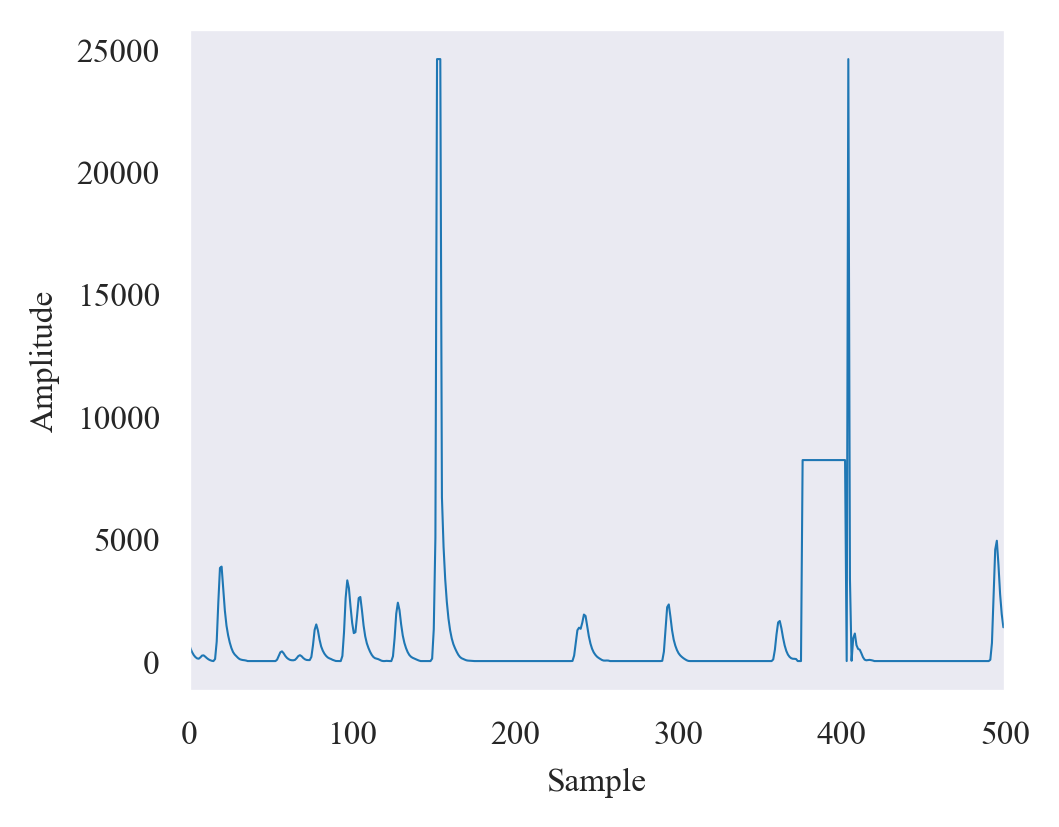

In [42]:
# goal: plot signal excerpt
# output: plot
# note dead-time of the detector
np.random.seed(43) # set random seed for reproducibility
idx = np.random.randint(0, len(s)-1000  )-400
plt.plot(s[idx:idx+500])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.xlim([0,500])
plt.savefig('signal_excerpt.png', bbox_inches='tight', transparent=False)
plt.show()

In [5]:
# calculate mode and median values
# goal: define DC threshold
from scipy import stats
(mode_value, _) = stats.mode(s, keepdims=True)
mode_value = mode_value[0][0]
median = np.median(s).astype('int16')
print(f'Mode value: {mode_value}, median: {median}')

Mode value: 8141, median: 8147


In [6]:
# DC threshold
dc_thr = median + 25 
s = s - dc_thr
s[s < 0] = 0

In [7]:
# goal: signal segmentation
# output: list of segments
# find zero crossings
d = np.sign(s[:-1]) - np.sign(s[1:])
zero_crossings_up = np.where(d < 0)[0]+1
zero_crossings_down = np.where(d > 0)[0]+1
pairs = np.vstack((zero_crossings_up, zero_crossings_down)).T

# create segments from pairs and convert to float64
segments = []
for pair in pairs:
    segments.append(s[pair[0]:pair[1]].astype('float64'))

print(f'Number of segments: {len(segments)}')
del pair, zero_crossings_up, zero_crossings_down 

Number of segments: 158813


Number of saturated (truncated) segments: 4109


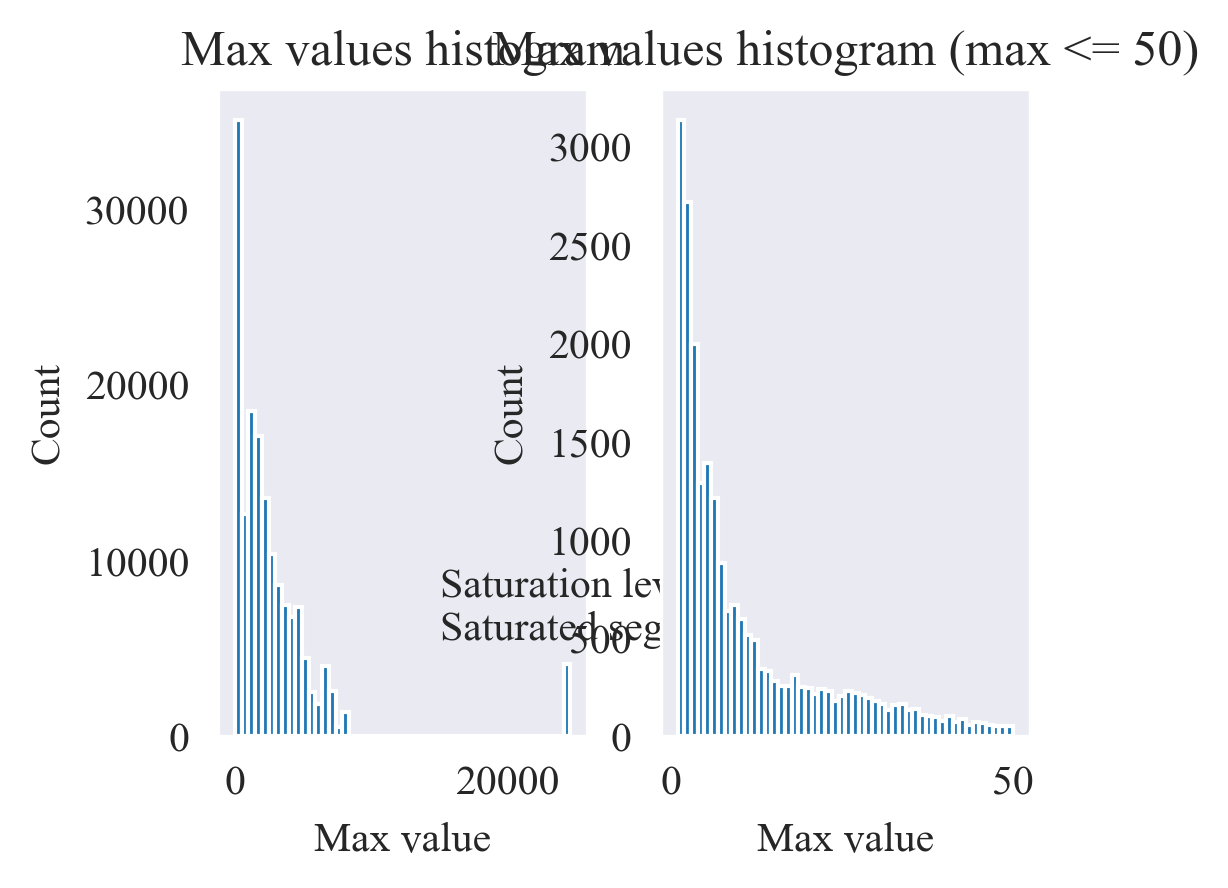

In [8]:
# goal: saturated segments statistics 
# max values statistics
max_values = np.array([np.max(x) for x in segments])
truncated_level = np.max(max_values)  # automatically detect truncation level
num_truncated_segments = np.sum(max_values >= truncated_level)
print(f'Number of saturated (truncated) segments: {num_truncated_segments}')

plt.subplot(1,2,1)
plt.hist(max_values, bins=50)
plt.text(0.6, 0.15, f'Saturation level: {truncated_level}\n'
                   f'Saturated segments: {num_truncated_segments}', transform=plt.gca().transAxes)
plt.xlabel('Max value')
plt.ylabel('Count')
plt.title('Max values histogram')
plt.grid()

min_maximum_value = 50

plt.subplot(1,2,2)
plt.hist(max_values[max_values <= min_maximum_value], bins=50)
plt.xlabel('Max value')
plt.ylabel('Count')
plt.title(f'Max values histogram (max <= {min_maximum_value})')
plt.grid()
plt.show()

In [9]:
# goal: remove saturated segments
print(f'Number of segments before saturated segments removal: {len(segments)}')
segments = [x for x in segments if np.max(x) < truncated_level]
print(f'Number of segments after saturated segments removal: {len(segments)}')

Number of segments before saturated segments removal: 158813
Number of segments after saturated segments removal: 154704


In [10]:
# goal: remove segments with max value less than min_maximum_value
print(f'Number of segments before min max value removal: {len(segments)}')
segments = [x for x in segments if np.max(x) >= min_maximum_value]
print(f'Number of segments after min max value removal: {len(segments)}')

Number of segments before min max value removal: 154704
Number of segments after min max value removal: 132902


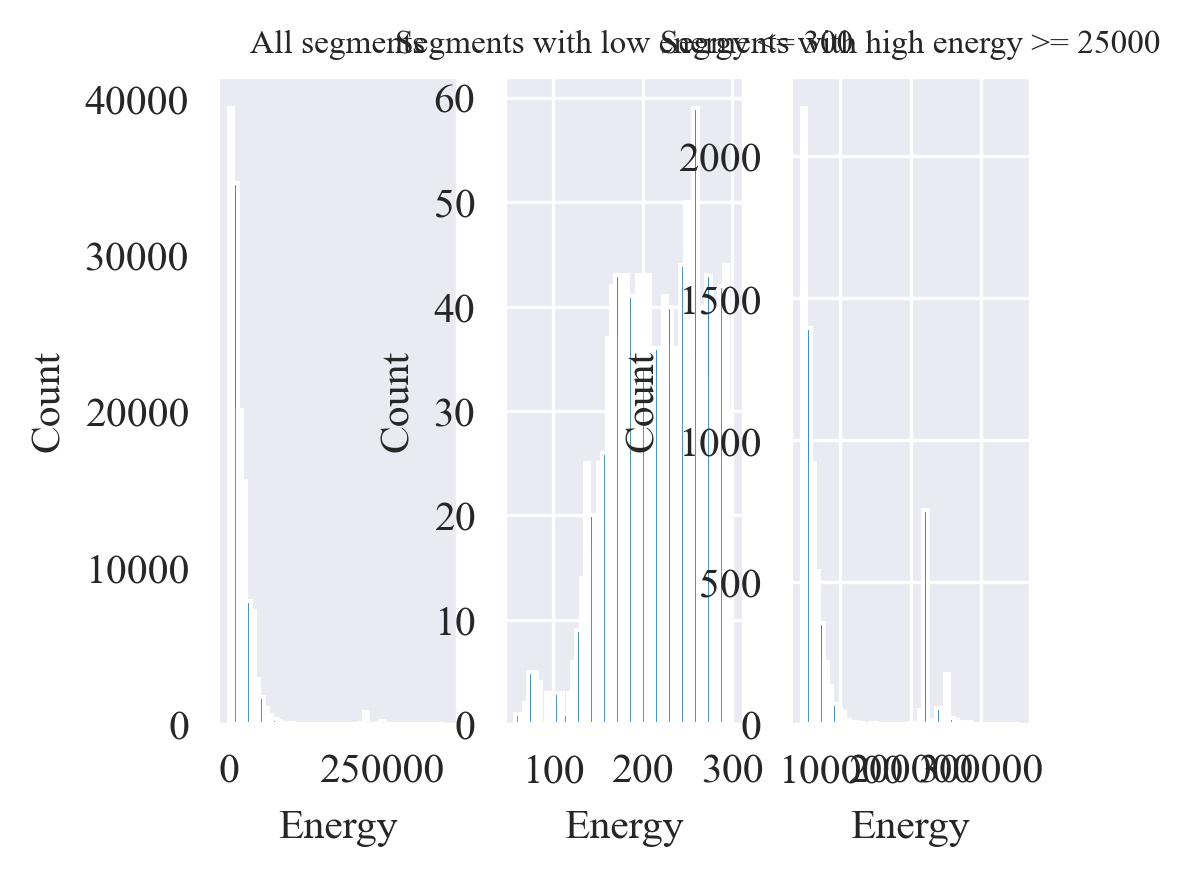

In [11]:
# goal: evaluate basic energy statistics and plot the resulting histogram
def sum_segments(x):
    return np.sum(x)

plt.rc('axes', titlesize=8)     # fontsize of the axes title
low_energy_threshold = 200
high_energy_threshold = 50000
energy_values = np.array([sum_segments(x) for x in segments])
plt.subplot(1,3,1)
plt.hist(energy_values, bins=50)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.title('All segments')
plt.grid()
plt.subplot(1,3,2)
plt.hist(energy_values[energy_values <= low_energy_threshold + 100], bins=50)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.title(f'Segments with low energy <= {low_energy_threshold + 100}')
plt.subplot(1,3,3)
plt.hist(energy_values[energy_values >= high_energy_threshold - 5000], bins=50)
plt.title(f'Segments with high energy >= {high_energy_threshold - 25000}')
plt.xlabel('Energy')
plt.ylabel('Count')
plt.show()

In [12]:
# goal: remove segments with too low or too high energy
print(f'Number of segments before energy removal: {len(segments)}')
segments = [x for x in segments if low_energy_threshold <= sum_segments(x) <= high_energy_threshold]
print(f'Number of segments after energy removal: {len(segments)}')

Number of segments before energy removal: 132902
Number of segments after energy removal: 127141


In [13]:
# goal: remove segments with minimum length requirement
min_length = 5
print(f'Number of segments before min length removal: {len(segments)}')
segments = [x for x in segments if x.shape[0] >= min_length]
print(f'Number of segments after min length removal: {len(segments)}')

Number of segments before min length removal: 127141
Number of segments after min length removal: 127093


In [14]:
# goal: evaluate number of peaks in segments
# output: number of peaks in segments
# three options: 
#   scipy.signal.argrelextrema : does not detect flat peaks 
#   scipy.signal.find_peaks: detects flat peaks and faster than argrelextrema
#   findpeaks: detects peaks at edges, the slowest
from scipy.signal import argrelextrema, find_peaks
# from findpeaks import findpeaks
def count_peaks2(x: np.ndarray) -> int:    
    # Assuming 'vector' is your 1-D numpy array
    # Define a comparator for argrelextrema to detect all peaks
    # flat peaks are not detected (i.e. peaks that have the same value around them) !!!
    comparator = np.greater
    
    # Find indices of relative maxima
    indices = argrelextrema(x, comparator)
    
    # Count the peaks
    num_peaks = len(indices[0])
    # print(f"Number of peaks: {num_peaks}")
    return num_peaks

def count_peaks(x: np.ndarray) -> int:
    return len(find_peaks(x.flatten())[0])

# def count_peaks3(x: np.ndarray) -> int:
#     # too slow !!!
#     fp = findpeaks(lookahead=1,method='topology',verbose=0)
#     results = fp.fit(x.flatten())
#     return results['df']['peak'].sum()

def count_peaks_on_edges(x: np.ndarray) -> int:
    if x[0] > x[1] or x[-1] > x[-2]:
        return 0
    else:
        return 1
    
def verify_peaks_count(x: np.ndarray) -> bool:
    return count_peaks(x) == count_peaks2(x) == count_peaks_on_edges(x) == 1

In [15]:
# goal: remove segments with peaks count different from 1
print(f'Number of segments before peaks count removal: {len(segments)}')
segments = [x for x in segments if verify_peaks_count(x) == True]
print(f'Number of segments after peaks count removal: {len(segments)}')

Number of segments before peaks count removal: 127093
Number of segments after peaks count removal: 93564


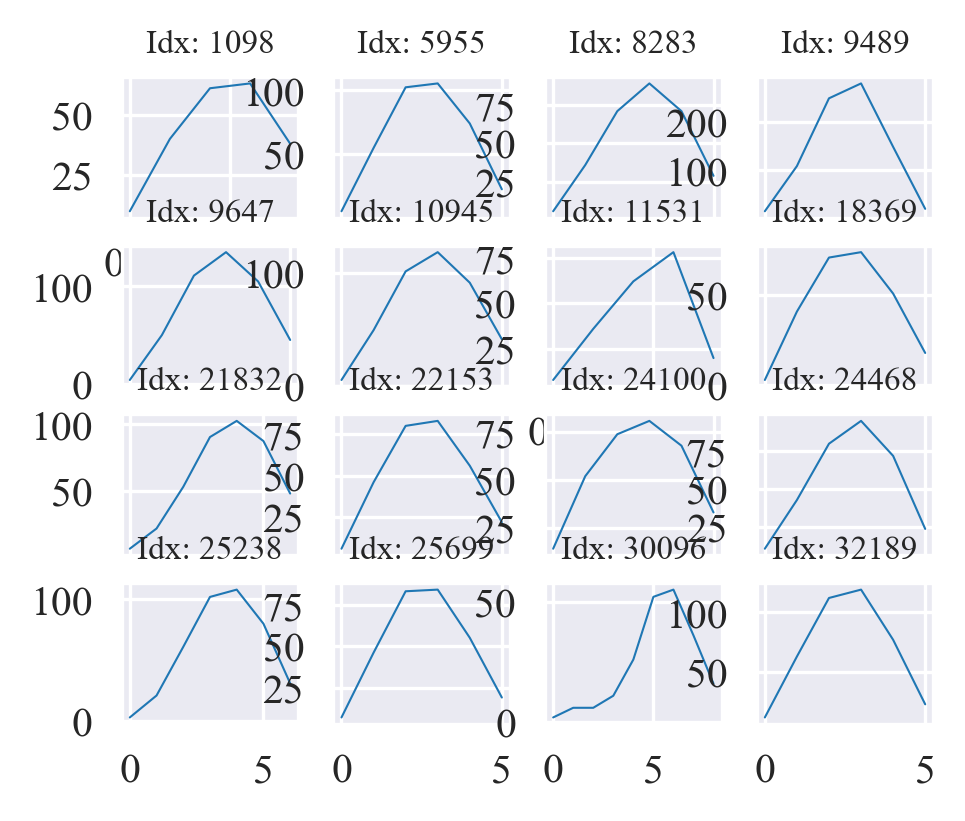

In [16]:
# check is segment maximum is in the first half of the segment
def is_max_in_first_half(x):
    return np.argmax(x) < x.shape[0] / 2

# plot examples
idx = 0
cnt = -1
for seg in segments:
    cnt += 1
    if is_max_in_first_half(seg):
        continue
    else:
        plt.subplot(4,4,idx+1)
        plt.plot(seg)
        plt.title(f'Idx: {cnt}')
        idx += 1
        if idx == 16:
            break

In [17]:
# goal: remove segments with maximum in the second half of the signal (non-downhill segments)
print(f'Number of segments before max in first half removal: {len(segments)}')
segments = [x for x in segments if is_max_in_first_half(x)]
print(f'Number of segments after max in first half removal: {len(segments)}')

Number of segments before max in first half removal: 93564
Number of segments after max in first half removal: 93514


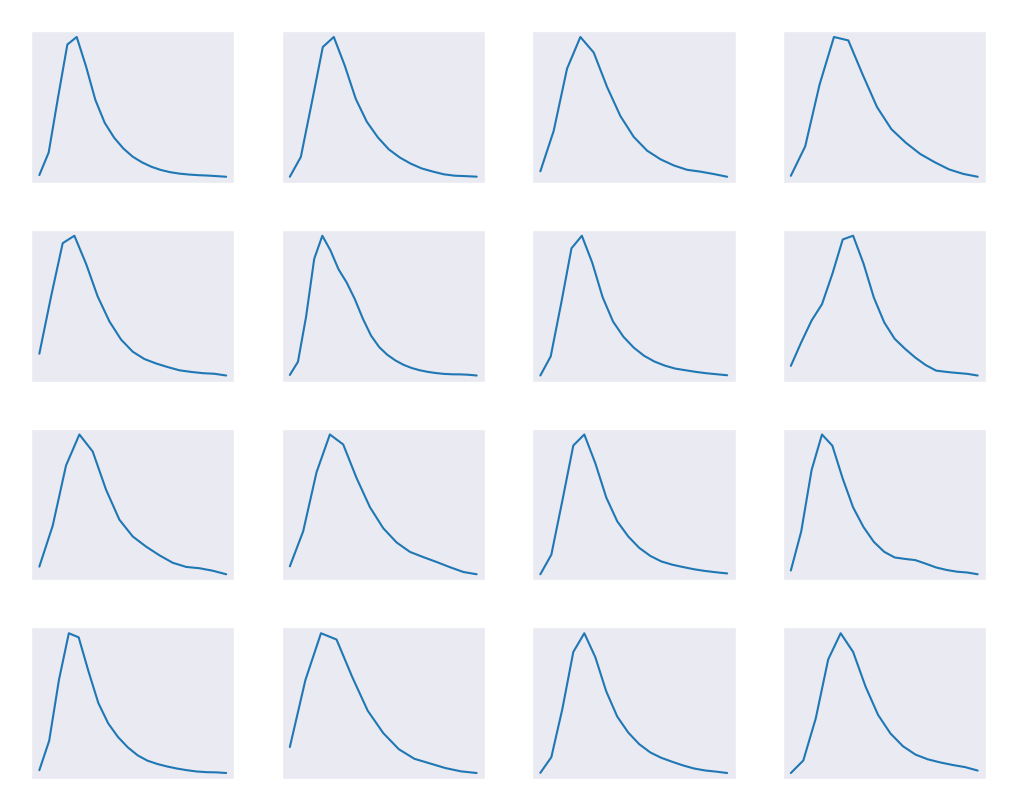

In [18]:
# plot segments examples
for i in range(16):
    plt.subplot(4,4,i+1)
    m = np.argmax(segments[i]).astype('int16')
    plt.plot(segments[i])
    plt.yticks([])
    plt.xticks([])
    #plt.title(f'Max value: {m}')
plt.tight_layout()
plt.savefig('signal_segments_examples.png', bbox_inches='tight')
plt.show()

Idx: 84952
Idx: 56107


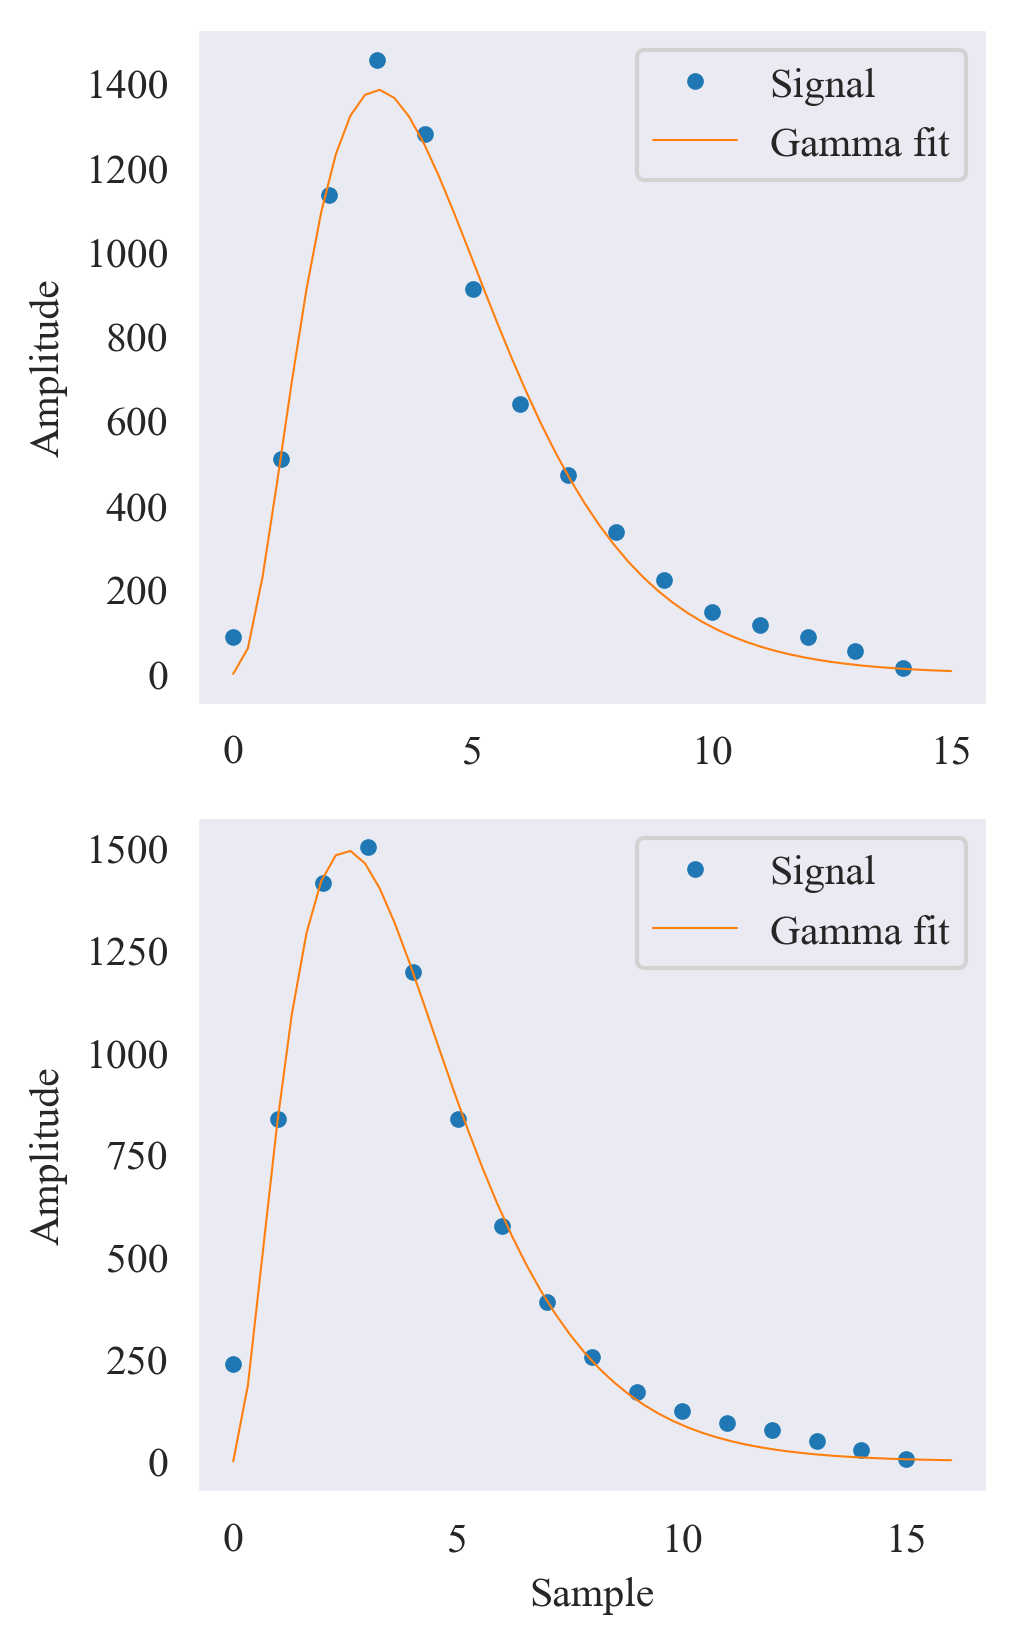

In [19]:
# goal: parameters estimation example
from scipy.optimize import least_squares

def fit_gamma_function(x, t, y):
    """Fit gamma function to data
    input:
        x: parameters, 
            x[0] - amplitude, 
            x[1] - shape,
            x[2] - scale,            
        t: time
        y: signal segment
    """
    return (x[0] * t**x[1] * np.exp(-x[2]*t) - y.T).flatten()

plt.figure(figsize=(3.49, 2.8*2))
# numerical example
for k, idx in enumerate(np.random.choice(range(len(segments)), 2, replace=False)):
    print(f'Idx: {idx}')
    seg = segments[idx]
    a2 = least_squares(fun=fit_gamma_function,
                       x0=[100, 4, 1],
                       # jac=jac_double_exponential,
                       loss='linear',
                       args=(np.arange(seg.shape[0]), seg),
                       bounds=([1   , 0.01 , 0],
                               [5000 , 15, 5]),
                       max_nfev=10000,
                       verbose=0
                       )
    # plot example
    plt.subplot(2,1,k+1)
    plt.plot(seg,'o',markersize=3)
    plt.plot(np.r_[0:seg.shape[0]:50j], a2.x[0] * np.r_[0:seg.shape[0]:50j]**a2.x[1] * np.exp(-a2.x[2]*np.r_[0:seg.shape[0]:50j]))
    plt.legend(['Signal', 'Gamma fit'])
    plt.ylabel('Amplitude')
    plt.grid()
    # print(f'a: {a.x[0]:.3f}, shape: {a.x[1]:.3f}, scale: {a.x[2]:.3f}, offset: {a.x[3]:.3f}'
    #       f'\nActive mask: {a.active_mask}, Status: {a.status}, Success: {a.success}'
    #       f'\nFunction runs: {a.nfev}, Cost: {a.cost:.3f}')
    # print(f'a: {a2.x[0]:.3f}, shape: {a2.x[1]:.3f}, scale: {a2.x[2]:.3f}'
    #       f'\nActive mask: {a2.active_mask}, Status: {a2.status}, Success: {a2.success}'
    #       f'\nFunction runs: {a2.nfev}, Cost: {a2.cost:.3f}')
plt.xlabel('Sample')
plt.tight_layout()
plt.savefig('signal_segments_fitting_gamma.png', bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = (3.49, 2.8)

In [20]:
# goal: parameters estimation for all segments
# note: this takes some time (about 5-10 minutes depending on the machine)
from tqdm import tqdm
sample_size = len(segments)
seg_sample = segments
optimal_parameters = np.empty((sample_size, 3))
active_masks = np.empty((sample_size, 3))
statuses = np.empty((sample_size, 1))
costs = np.empty((sample_size, 1))
for idx, seg in tqdm(enumerate(seg_sample)):
    a = least_squares(fun=fit_gamma_function,
                      x0=[200, 4, 1],
                      loss='linear',
                      args=(np.arange(seg.shape[0]), seg),
                      bounds=([0.5   , 0.001 , 0],
                              [6000 , 15, 5]),
                      max_nfev=10000,
                      xtol=1e-4,
                      verbose=0
                      )
    optimal_parameters[idx,:] = a.x.reshape((1,-1))
    costs[idx,:] = a.cost.squeeze()
    active_masks[idx,:] = a.active_mask.reshape((1,-1))
    statuses[idx,:] = a.status

93514it [05:37, 276.76it/s]


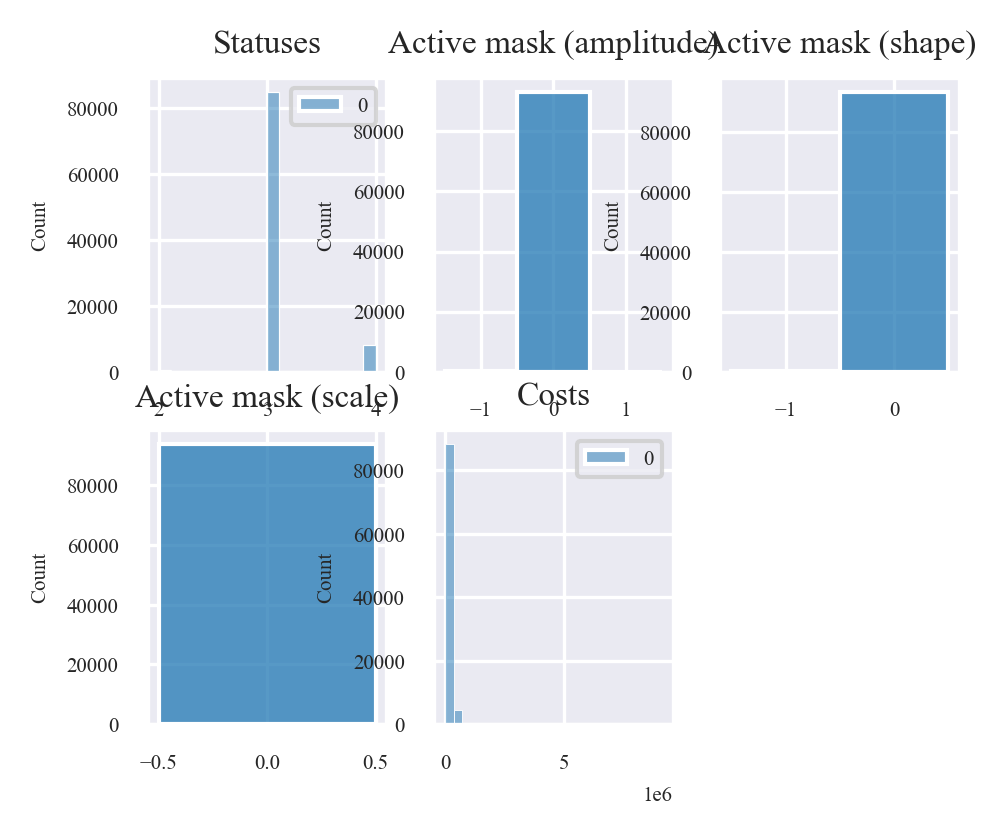

In [21]:
# goal: plot fit debug information
plt.rcParams['font.size'] = 5
plt.subplot(2,3,1)
sns.histplot(statuses)
plt.title('Statuses')
plt.subplot(2,3,2)
sns.histplot(active_masks[:,0], discrete=True)
plt.title('Active mask (amplitude)')
plt.subplot(2,3,3)
sns.histplot(active_masks[:,1], discrete=True)
plt.title('Active mask (shape)')
plt.subplot(2,3,4)
sns.histplot(active_masks[:,2], discrete=True)
plt.title('Active mask (scale)')
plt.subplot(2,3,5)
sns.histplot(costs, bins=25)
plt.title('Costs')
plt.show()

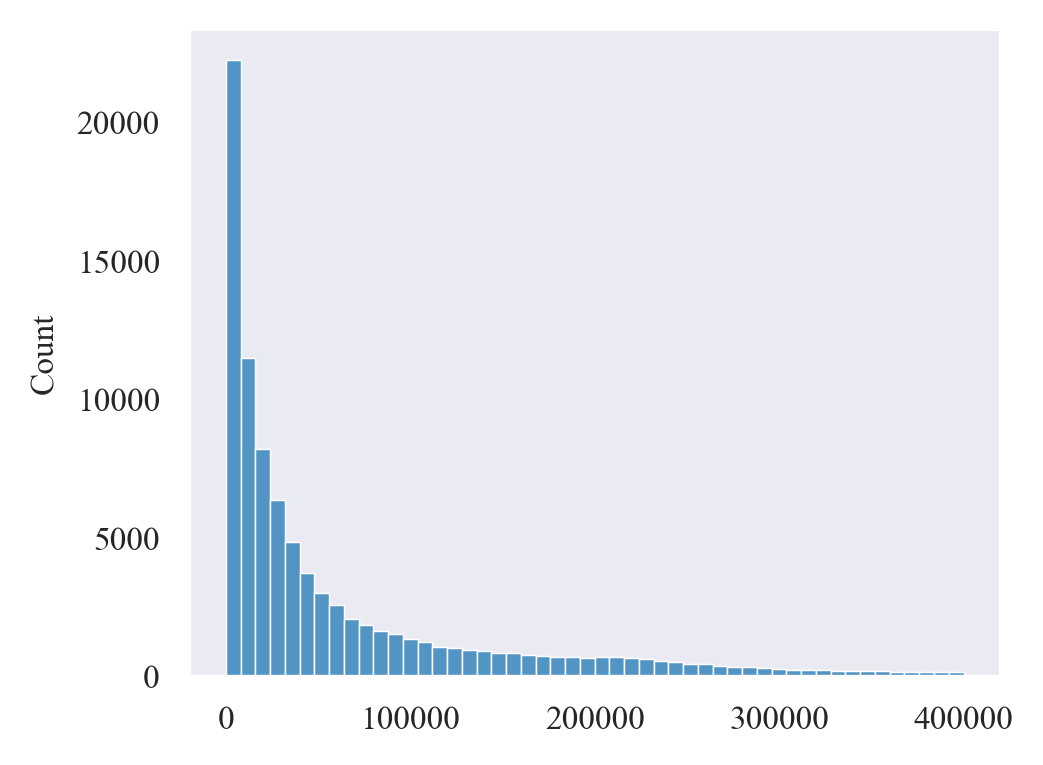

In [22]:
# goal: close-up of cost function results
plt.rcParams['font.size'] = 8
sns.histplot(costs[costs < 400000], bins=50)
plt.grid()
plt.show()
costs_threshold = 10000
idx = np.where(costs > costs_threshold)[0]

In [23]:
# goal: remove segments with cost function value greater than costs_threshold
print(f'Number of segments before cost function removal: {len(segments)}')
segments = [x for i, x in enumerate(segments) if i in idx]
print(f'Number of segments after cost function removal: {len(segments)}')

Number of segments before cost function removal: 93514
Number of segments after cost function removal: 68007


In [24]:
# calculate histogram of parameters and save them
alpha_param = optimal_parameters[idx,1]
beta_param = optimal_parameters[idx,2]
mask1 = np.logical_and(alpha_param > 1, alpha_param < 6.5)
mask2 = np.logical_and(beta_param < 1.2, beta_param > 0.3)
mask = np.logical_and(mask1, mask2)
alpha_param = alpha_param[mask]
beta_param = beta_param[mask]

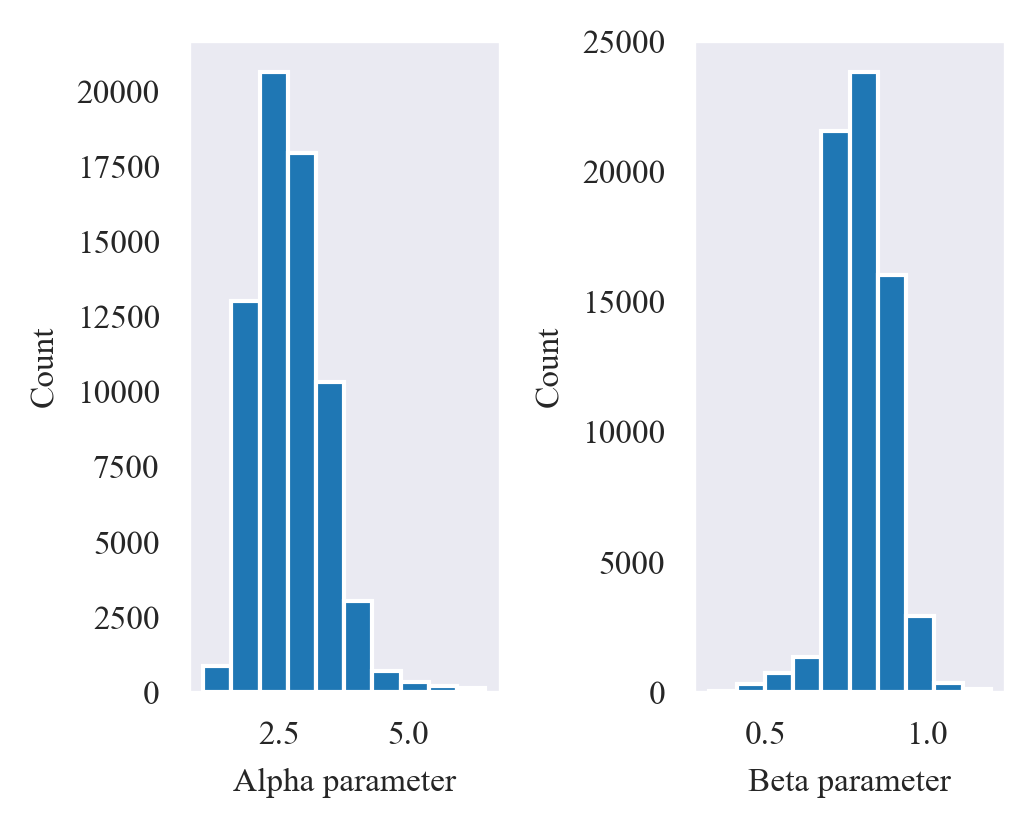

In [25]:
plt.subplot(1,2,1)
weight_alpha, edges = np.histogram(alpha_param, bins=50)
centers_alpha = (edges[:-1] + edges[1:]) / 2
# these above are saved in the npz file
plt.hist(alpha_param)
plt.xlabel('Alpha parameter')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
# plt.savefig('alpha_param.png', bbox_inches='tight', transparent=True)
# plt.show()
plt.subplot(1,2,2)
weight_beta, edges = np.histogram(beta_param, bins=50)
centers_beta = (edges[:-1] + edges[1:]) / 2
# these above are saved in the npz file
plt.hist(beta_param)
plt.xlabel('Beta parameter')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
# plt.savefig('beta_param.png', bbox_inches='tight', transparent=True)
plt.savefig('alpha_beta_param.png', bbox_inches='tight')
plt.show()
np.savez('gamma_shape_parameters.npz', weight_alpha=weight_alpha, centers_alpha=centers_alpha,
         weight_beta=weight_beta, centers_beta=centers_beta)

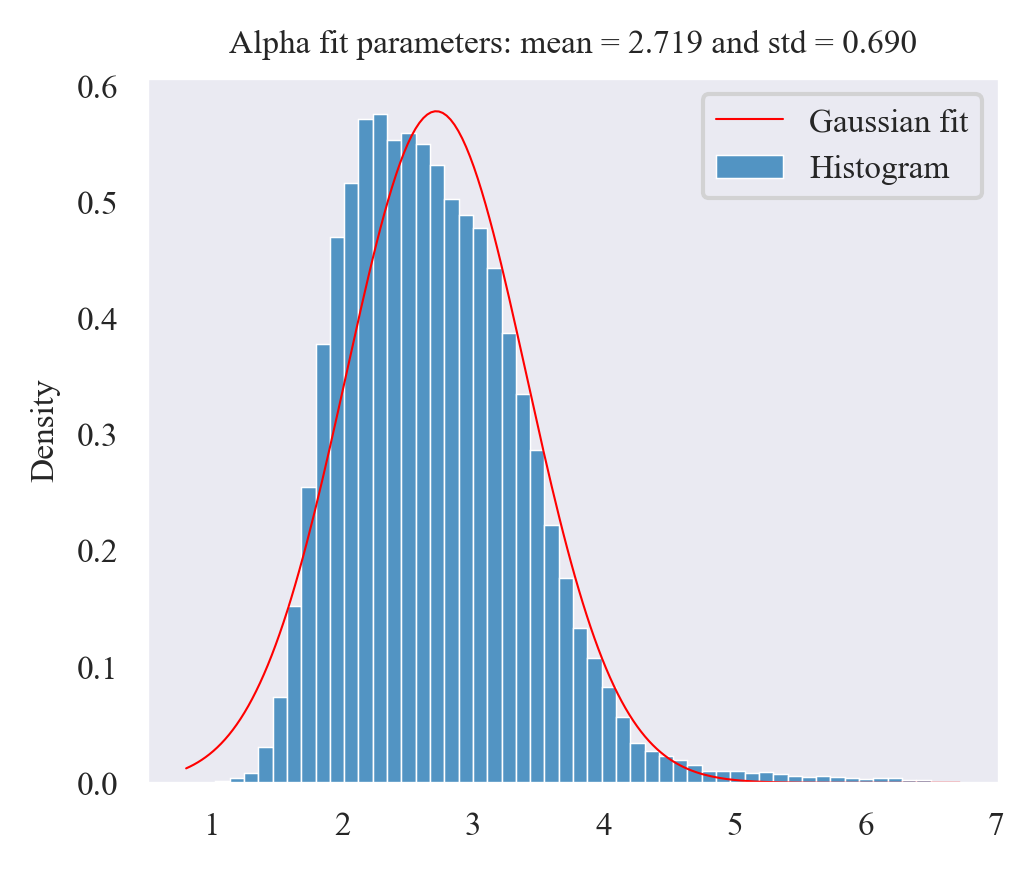

Alpha fit parameters: mean = 2.719 and std = 0.690


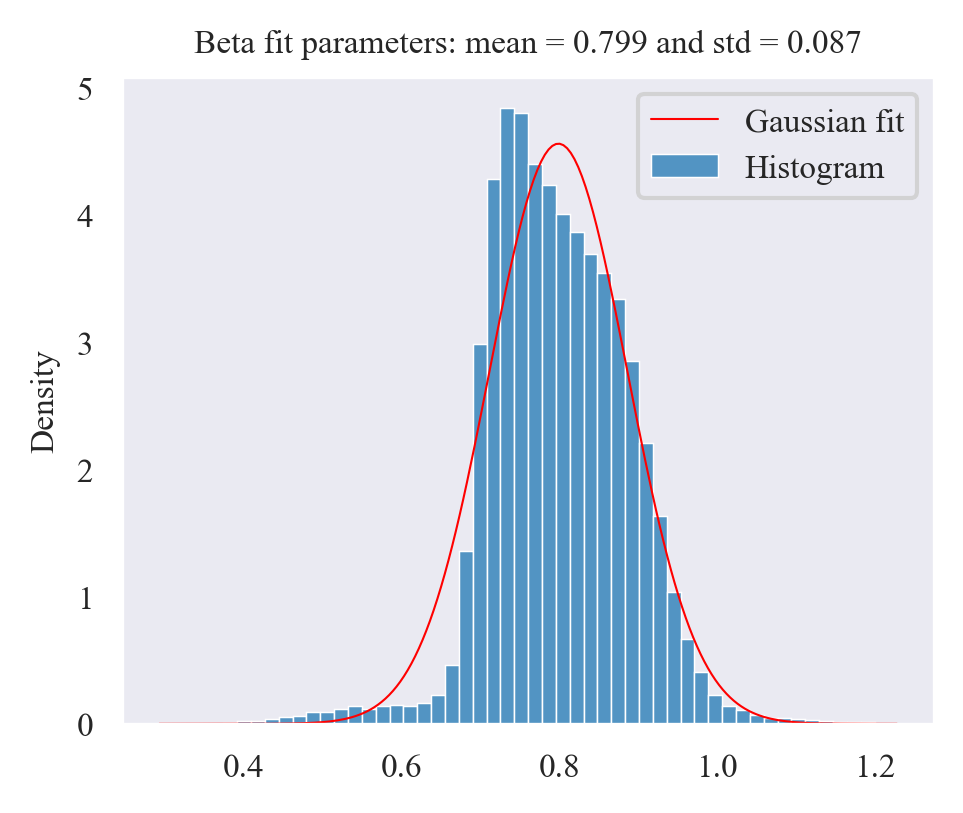

Beta fit parameters: mean = 0.799 and std = 0.087


In [26]:
# goal: normal distribution fit of gamma-shape parameters
# https://stackoverflow.com/questions/69059121/how-to-draw-a-normal-curve-on-seaborn-displot
ax = sns.histplot(alpha_param, bins=50, stat='density', label='Histogram')
# compute bandwidth
bw = len(alpha_param)**(-1/5) * alpha_param.std(ddof=1)
# initialize PDF support
x = np.linspace(alpha_param.min()-bw*3, alpha_param.max()+bw*3, 200)
# compute PDF parameters
params = stats.norm.fit(alpha_param)
# compute PDF values
y = stats.norm.pdf(x, *params)
# plot the fitted continuous distribution
ax.plot(x, y, color='red', label='Gaussian fit')
plt.legend()
plt.grid()
plt.tight_layout()
plt.title(f'Alpha fit parameters: mean = {params[0]:.3f} and std = {params[1]:.3f}')
plt.show()
print(f'Alpha fit parameters: mean = {params[0]:.3f} and std = {params[1]:.3f}')

ax = sns.histplot(beta_param, bins=50, stat='density', label='Histogram')
# compute bandwidth
bw = len(beta_param)**(-1/5) * beta_param.std(ddof=1)
# initialize PDF support
x = np.linspace(beta_param.min()-bw*3, beta_param.max()+bw*3, 200)
# compute PDF parameters
params = stats.norm.fit(beta_param)
# compute PDF values
y = stats.norm.pdf(x, *params)
# plot the fitted continuous distribution
ax.plot(x, y, color='red', label='Gaussian fit')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.title(f'Beta fit parameters: mean = {params[0]:.3f} and std = {params[1]:.3f}')
plt.show()
print(f'Beta fit parameters: mean = {params[0]:.3f} and std = {params[1]:.3f}')

In [33]:
# goal: calculate energy of segments
energy = np.empty((len(segments), 1))
for i, segment in enumerate(segments):
    energy[i] = sum_segments(segment)

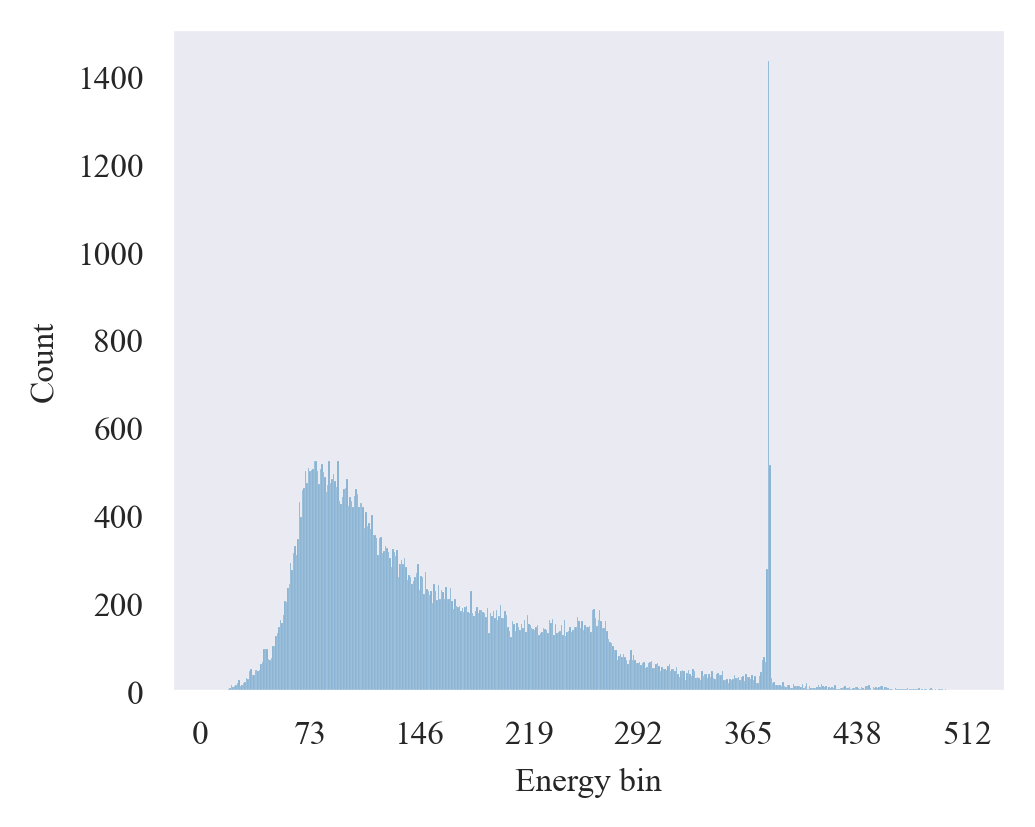

In [41]:
# plot energy histogram with 512 bins
counts, bins = np.histogram(energy, bins=512)
bin_centers = (bins[:-1] + bins[1:]) / 2
# these above are saved in the npz file
sns.histplot(energy, bins=512)
plt.xticks(np.r_[0:np.max(bins):8j],labels=np.r_[0:512:8j].astype('int16'))
#plt.gca().set_xticklabels(np.r_[0:513:64])
plt.xlabel('Energy bin')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
plt.legend([],[], frameon=False)
plt.savefig('signal_energy_histogram.png', bbox_inches='tight', transparent=False)
plt.show()

# save energy histogram
np.savez('energy_histogram.npz', energy_bins=bin_centers, energy_weights=counts)